<a href="https://colab.research.google.com/github/douhua2882/Transformer/blob/main/Multihead_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

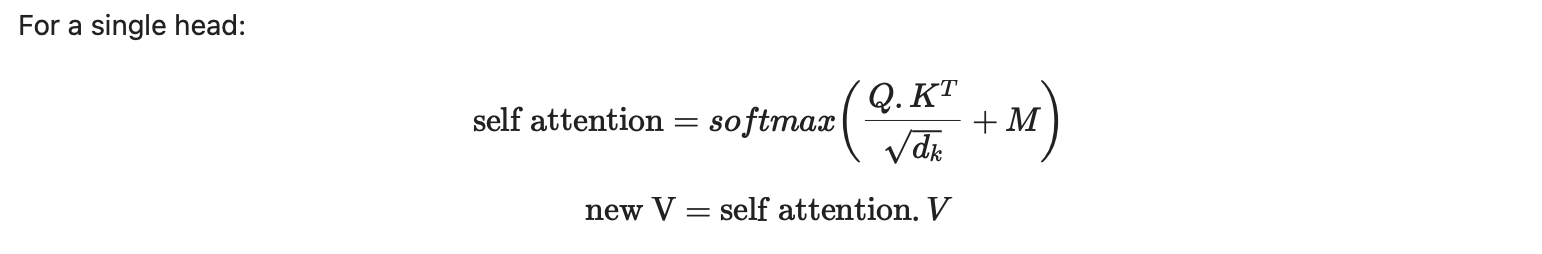

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
sequence_length = 5
batch_size  = 1
input_dim = 512
d_model = 512        # d_model is the dimension of input/output embeddings
x = torch.randn((batch_size, sequence_length, input_dim))

In [ ]:
x.size()

torch.Size([1, 5, 512])

In [ ]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [ ]:
qkv = qkv_layer(x)

In [ ]:
qkv.shape

torch.Size([1, 5, 1536])

Text(0.5, 1.0, 'qkv distribution')

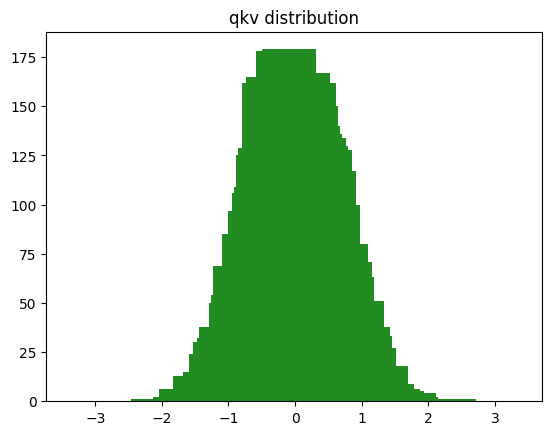

In [ ]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

torch.Size([1, 5, 8, 192])

In [ ]:
qkv = qkv.permute(0, 2, 1, 3)  # change the order to be [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 5, 192])

In [ ]:
q, k, v = qkv.chunk(3, dim=-1)    # why dim = -1?
q.shape, k.shape, v.shape


(torch.Size([1, 8, 5, 64]),
 torch.Size([1, 8, 5, 64]),
 torch.Size([1, 8, 5, 64]))

## Self Attention for multiple heads

In [ ]:
import math

d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 5, 5])

In [ ]:
k.transpose(-2, -1).shape

torch.Size([1, 8, 64, 5])

In [ ]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 5])

In [ ]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 0.6146,  0.5428],
        [-1.2212,  0.6207],
        [ 0.7110,  1.0539]])

In [ ]:
y

tensor([[ 0.6146, -1.2212,  0.7110],
        [ 0.5428,  0.6207,  1.0539]])

In [ ]:
torch.transpose(y, 1, 0)

tensor([[ 0.6146,  0.5428],
        [-1.2212,  0.6207],
        [ 0.7110,  1.0539]])

In [ ]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          ...,
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          ...,
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          ...,
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         ...,

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          ...,
          [True, True, True, True, Tr

In [ ]:
# Decoder - mask
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)  # torch.triu() returns the upper triangular part of a given matrix.
# diagonal=1 argument ensures that the main diagonal and all elements below it are set to zero, keeping only the upper triangular portion.
mask[0][0]

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[ 0.4577,    -inf,    -inf,    -inf,    -inf],
        [-0.3385, -0.1367,    -inf,    -inf,    -inf],
        [-0.3899, -0.0887, -0.2307,    -inf,    -inf],
        [-0.2018, -0.1208,  0.1164,  0.0400,    -inf],
        [ 0.0694, -0.1613, -0.2061,  0.3695,  0.2501]],
       grad_fn=<SelectBackward0>)

In [ ]:
scaled += mask

In [ ]:
np.exp(-0.3385) / np.exp(-0.3385) + np.exp(-0.1367)

1.8722318564425335

In [ ]:
attention = F.softmax(scaled, dim=-1)

In [ ]:
attention.shape

torch.Size([1, 8, 5, 5])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4497, 0.5503, 0.0000, 0.0000, 0.0000],
        [0.2838, 0.3835, 0.3327, 0.0000, 0.0000],
        [0.2113, 0.2291, 0.2905, 0.2691, 0.0000],
        [0.1960, 0.1557, 0.1488, 0.2646, 0.2348]], grad_fn=<SelectBackward0>)

In [ ]:
values = torch.matmul(attention, v)  # matrix multiplication
values.shape

torch.Size([1, 8, 5, 64])

## Function

In [ ]:
import math

def scaled_dot_product(q, k, v, mask=None):
  d_k = q.size()[-1]   # d_k is the query dimension (usually 64 or 128)
  scaled = torch.matmul(q, k.transpose(-1,-2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
values, attention = scaled_dot_product(q, k, v, mask)

In [ ]:
attention.shape

torch.Size([1, 8, 5, 5])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4497, 0.5503, 0.0000, 0.0000, 0.0000],
        [0.2838, 0.3835, 0.3327, 0.0000, 0.0000],
        [0.2113, 0.2291, 0.2905, 0.2691, 0.0000],
        [0.1960, 0.1557, 0.1488, 0.2646, 0.2348]], grad_fn=<SelectBackward0>)

In [ ]:
values.shape

torch.Size([1, 8, 5, 64])

In [ ]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.shape

torch.Size([1, 5, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
out = linear_layer(values)

In [ ]:
out.shape

torch.Size([1, 5, 512])

In [ ]:
out

tensor([[[ 0.0431,  0.2370,  0.0741,  ..., -0.0567,  0.6467, -0.2376],
         [ 0.2371, -0.3785,  0.4787,  ..., -0.0564,  0.3062, -0.0180],
         [-0.3282,  0.1249, -0.0432,  ..., -0.0925, -0.1732, -0.3402],
         [ 0.0524,  0.2317,  0.3879,  ..., -0.0821,  0.2571,  0.0983],
         [-0.1832, -0.2286,  0.1172,  ..., -0.3194, -0.2448, -0.0890]]],
       grad_fn=<ViewBackward0>)

Class

In [ ]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim=-1)     # Applies softmax along the last axis, ensuring that values sum to 1 across that dimension.
  values = torch.matmul(attention, v)
  return values, attention

class MultiHeadAttention(nn.Module):

  def __init__(self, input_dim, d_model, num_heads):
    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, x, mask=None):
    batch_size, sequence_length, input_dim = x.size()
    print(f"x.size(): {x.size()}")
    qkv = self.qkv_layer(x)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.permute(0, 2, 1, 3)
    print(f"qkv.size(): {qkv.size()}")
    q, k, v = qkv.chunk(3, dim=-1)    # .chunk() splits a tensor into 3 parts along the specified dimension
    print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}")
    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values.size: {values.size()}, attention.size: {attention.size()}")
    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    print(f"values.size: {values.size()}")
    out = self.linear_layer(values)
    print(f"out.size: {out.size()}")
    return out

## Input

In [ ]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64])
values.size: torch.Size([30, 8, 5, 64]), attention.size: torch.Size([30, 8, 5, 5])
values.size: torch.Size([30, 5, 512])
out.size: torch.Size([30, 5, 512])
